## Project 4
Yahir Ocegueda

In [ ]:
!pip install -q -U keras-tuner

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import seaborn as sns
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
%matplotlib inline
import cv2
import glob
from IPython.display import Image
import scipy as sp
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Input, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization, concatenate, LSTM
from sklearn.preprocessing import StandardScaler,  OneHotEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from keras.optimizers import Adam

In [ ]:
def chart_regression(pred,y,sort=True):
  # Convert pred and y to NumPy arrays (in case they're pandas Series or other types)
    pred = np.array(pred)
    y = np.array(y)
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

In [ ]:
file_path ="/content/drive/MyDrive/CSC180/Project 4/Dataset/GOOG.csv"
df = pd.read_csv(file_path)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3578 entries, 0 to 3577
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3578 non-null   object 
 1   Open       3578 non-null   float64
 2   High       3578 non-null   float64
 3   Low        3578 non-null   float64
 4   Close      3578 non-null   float64
 5   Adj Close  3578 non-null   float64
 6   Volume     3578 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 195.8+ KB
None


In [ ]:
#Remove date and adj close, and duplicate the close column and rename for readability
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

df['Close Input'] = df['Close']
df['Close Output'] = df['Close']

# Drop the old 'Close' column
df = df.drop(columns=['Close'])


df.head(15)

,Open,High,Low,Volume,Close Input,Close Output
0,49.676899,51.693783,47.669952,44994500,49.845802,49.845802
1,50.178635,54.187561,49.925285,23005800,53.805050,53.805050
2,55.017166,56.373344,54.172661,18393200,54.346527,54.346527
3,55.260582,55.439419,51.450363,15361800,52.096165,52.096165
4,52.140873,53.651051,51.604362,9257400,52.657513,52.657513
5,52.135906,53.626213,51.991844,7148200,53.606342,53.606342
6,53.700729,53.959049,52.503513,6258300,52.732029,52.732029
7,52.299839,52.404160,50.675404,5235700,50.675404,50.675404
8,50.819469,51.519913,50.749920,4954800,50.854240,50.854240
9,51.018177,51.152302,49.512966,9206800,49.801090,49.801090


In [ ]:
#build the data so that you use the first 1-7 row of data to predict the 8th day close price, and then use the 2-8 day data to predict the 9th day close price and so on. Sliding window
x = []
y = []

for i in range (7, len(df)):
  x.append(df.iloc[i-7: i, :-1].values) # this is the last 7 days worth of data
  y.append(df.iloc[i, -1]) #this would be the close price

In [ ]:
# Set print options to suppress scientific notation
np.set_printoptions(suppress=True)
print("These are the first set of x values\n", x[0],"\n")
print("This is the first y value we are trying to predict = ", y[0])



These are the first set of x values
 [[      49.676899       51.693783       47.669952 44994500.
        49.845802]
 [      50.178635       54.187561       49.925285 23005800.
        53.80505 ]
 [      55.017166       56.373344       54.172661 18393200.
        54.346527]
 [      55.260582       55.439419       51.450363 15361800.
        52.096165]
 [      52.140873       53.651051       51.604362  9257400.
        52.657513]
 [      52.135906       53.626213       51.991844  7148200.
        53.606342]
 [      53.700729       53.959049       52.503513  6258300.
        52.732029]] 

This is the first y value we are trying to predict =  50.675404


In [ ]:
x, y = np.array(x), np.array(y)

# Split into training and test sets (70/30)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)

#normalize the input features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

In [ ]:
print("This is x train", x_train.shape)
print("This is x test", x_test.shape)
print("This is y train", y_train.shape)
print("This is y test", y_test.shape)

print(x_train.shape[1])

This is x train (2499, 7, 5)
This is x test (1072, 7, 5)
This is y train (2499,)
This is y test (1072,)
7


## FNN

In [ ]:
x_train_FNN =  x_train.reshape(x_train.shape[0], -1)
x_test_FNN = x_test.reshape(x_test.shape[0], -1)
print("This is x train_FNN", x_train_FNN.shape)
print("This is x test_FNN", x_test_FNN.shape)

This is x train_FNN (2499, 35)
This is x test_FNN (1072, 35)


In [ ]:
print(x_train_FNN)
print(x_test_FNN)

[[-0.82176087 -0.81866103 -0.8139689  ... -0.84325714  0.45311754
  -0.84330744]
 [-0.52576211 -0.51970251 -0.52184014 ... -0.41480049 -0.14595426
  -0.42023673]
 [-0.85910419 -0.8500022  -0.85438701 ... -0.8302869   0.57971289
  -0.83605478]
 ...
 [ 0.30085229  0.32011916  0.3104843  ...  0.46283366 -0.72807362
   0.44735529]
 [-0.55827012 -0.55102649 -0.54835905 ... -0.49058884 -0.25480555
  -0.50043325]
 [-0.56896694 -0.56178429 -0.56732374 ... -0.56614934 -0.19168447
  -0.57035072]]
[[-0.3647873  -0.35451822 -0.40812253 ... -0.39644933  1.48262569
  -0.3804255 ]
 [ 1.13598462  1.13200632  1.13891384 ...  0.92527686 -0.62684606
   0.91790974]
 [-0.51972666 -0.52132575 -0.51479415 ... -0.47108093 -0.51190553
  -0.47839704]
 ...
 [-0.85833893 -0.86208966 -0.87969658 ... -0.87997701  0.97864348
  -0.87755309]
 [ 0.01744732  0.0232335   0.03169183 ...  0.04876349 -0.30208242
   0.03852317]
 [-0.66005558 -0.66390643 -0.65257683 ... -0.64598656  0.24095618
  -0.65186903]]


In [ ]:
model = Sequential() # model arch

# Input layer
model.add(Dense(256, activation='relu', input_shape=(x_train_FNN.shape[1],)))

# Hidden layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
# model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train_FNN, y_train,
    validation_data=(x_test_FNN, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 231193.3906 - val_loss: 28337.9277
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22653.3242 - val_loss: 11442.4980
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10350.5547 - val_loss: 7632.8647
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8135.5630 - val_loss: 6426.1768
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5865.6587 - val_loss: 4980.1055
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4633.0430 - val_loss: 3020.6338
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2566.6326 - val_loss: 1463.1981
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1158.6912 - val_loss: 624.0555
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 445.2860 - val_loss: 303.9807
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 216.2179 - val_loss: 346.1529
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 233.3388 - val_loss: 233.214

In [ ]:
# Predict on test data
y_pred_FNN = model.predict(x_test_FNN)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_FNN))
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 9.41


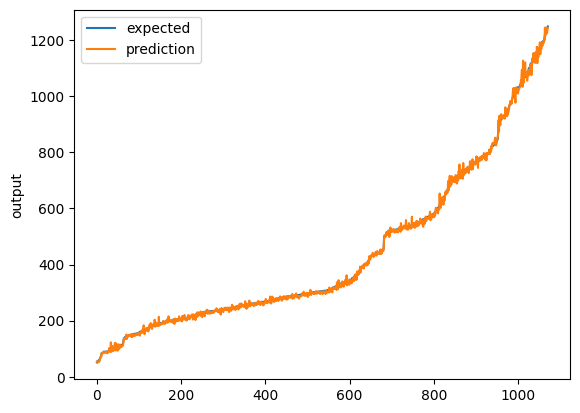

In [ ]:
chart_regression(y_pred_FNN.flatten(),y_test, sort=True)

## CNN


#### Important functions for Tensorflow from labs

In [ ]:
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

### CNN Definition

In [ ]:
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

cnn = Sequential()
cnn.add(Conv1D(512, kernel_size=4, activation='relu', input_shape=(7, 5)))
cnn.add(Conv1D(128, kernel_size=2, activation='relu'))
cnn.add(Conv1D(64, kernel_size=2, activation='relu'))
cnn.add(Conv1D(32, kernel_size=2, activation='relu'))
cnn.add(Flatten())
cnn.add(Dense(100, activation='relu'))
cnn.add(Dense(50, activation='relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(1))

cnn.compile(optimizer="adam", loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### CNN Early Stopping and Saving Best Model

In [ ]:
# Early Stopping & Save best model
monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpointer = ModelCheckpoint(filepath="best_cnn.keras", verbose=0, save_best_only=True)


### Training the CNN Model

In [ ]:
cnn.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, callbacks=[monitor, checkpointer])
cnn.load_weights("best_cnn.keras")

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 127341.4141 - val_loss: 5511.1924
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12119.9121 - val_loss: 3518.8123
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7479.4019 - val_loss: 866.6974
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7703.6475 - val_loss: 1412.4279
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6962.8799 - val_loss: 795.6256
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6175.5601 - val_loss: 842.4409
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7465.3394 - val_loss: 474.0902
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6202.8457 - val_loss: 544.1793
Epoch 9/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7622.1660 - val_loss: 4030.9922
Epoch 10/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6747.0840 - val_loss: 563.0460
Epoch 11/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7363.4956

### Predict and evaluate the CNN Model




In [ ]:
y_pred_cnn = cnn.predict(x_test)
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
print("RMSE for the CNN model: {rmse}".format(rmse = rmse_cnn))

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RMSE for the CNN model: 15.842191407040282


###Lift Chart for CNN



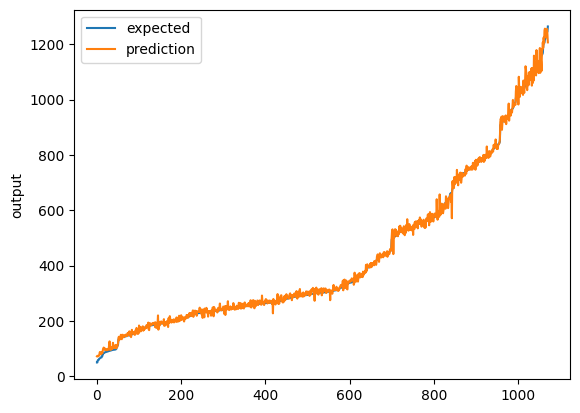

In [ ]:
chart_regression(y_pred_cnn.flatten(),y_test, sort=True)

# LSTM Model


In [ ]:
print("This is x train", x_train.shape)
print("This is x test", x_test.shape)
print("This is y train", y_train.shape)
print("This is y test", y_test.shape)

This is x train (2499, 7, 5)
This is x test (1072, 7, 5)
This is y train (2499,)
This is y test (1072,)


In [ ]:
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/CSC180/Best_LSTM_Model.keras', save_best_only=True)
for i in range(5):
  lstm_model = Sequential([
    LSTM(64, input_shape=(7, 5)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for predicting the Close price
  ])

  # Compile and train LSTM model 0.0005
  lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

  # Define callbacks
  early_stop = EarlyStopping(monitor='val_loss', patience=5)

  history = lstm_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=32,
                        callbacks=[early_stop, model_checkpoint])



Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 266441.0312 - val_loss: 257145.1719
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 238506.1719 - val_loss: 217971.1406
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 199502.1875 - val_loss: 178524.6562
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 165627.3906 - val_loss: 142745.1562
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 127778.2188 - val_loss: 113658.9453
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 113194.9297 - val_loss: 88099.0469
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 75555.7031 - val_loss: 66286.8750
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 61251.4922 - val_loss: 48748.3750
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 43914.7891 - val_loss: 35967.5469
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30152.5996 - val_loss: 26453.9805
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
LSTM RMSE: 9.823002977435067


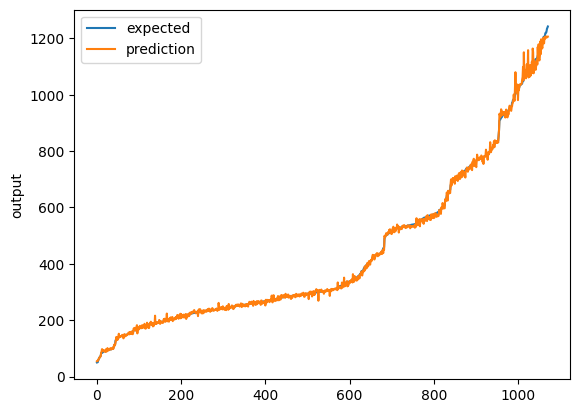

In [ ]:
# Load best LSTM model and evaluate
lstm_model.load_weights('/content/drive/MyDrive/CSC180/Best_LSTM_Model.keras')
lstm_predictions = lstm_model.predict(x_test)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
print('LSTM RMSE:', lstm_rmse)

# Plot regression lift chart for LSTM
chart_regression(lstm_predictions.flatten(), y_test)

# <b>Additional Features</b>
## <b>Finding the best N value (number of days we should look back in the past) that yields the most accurate model</b>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn import metrics

In [ ]:
import os
from tensorflow.keras.models import save_model

In [ ]:
# Reading and setting up dataset
file_path ="/content/drive/MyDrive/CSC180/Project 4/Dataset/GOOG.csv"
df = pd.read_csv(file_path)
df = df[['Open', 'High', 'Low', 'Volume', 'Close']].copy()
df['Close Input'] = df['Close']
df = df.drop(columns=['Close'])
df.head(15)

,Open,High,Low,Volume,Close Input
0,49.676899,51.693783,47.669952,44994500,49.845802
1,50.178635,54.187561,49.925285,23005800,53.805050
2,55.017166,56.373344,54.172661,18393200,54.346527
3,55.260582,55.439419,51.450363,15361800,52.096165
4,52.140873,53.651051,51.604362,9257400,52.657513
5,52.135906,53.626213,51.991844,7148200,53.606342
6,53.700729,53.959049,52.503513,6258300,52.732029
7,52.299839,52.404160,50.675404,5235700,50.675404
8,50.819469,51.519913,50.749920,4954800,50.854240
9,51.018177,51.152302,49.512966,9206800,49.801090


In [ ]:
# Defining a range of N values that will be tested
N_values = [2, 3, 5, 7, 10, 14, 18, 21, 25, 28]

In [ ]:

rmse_results = []  # Ensure rmse list is empty before starting the loop

# For saving best model
best_rmse = float('inf')
best_model = None
best_N = None
best_predictions = None
best_actuals = None

# Loop over each value of N in list of N_values
for N in N_values:
    X, Y = [], [] # Initialize empty lists to hold the input features (X) and the output target (Y)
    for i in range(N, len(df)):
        X.append(df.iloc[i-N:i, :].values.flatten())  # Append flattened array of last N days' data to X
        Y.append(df.iloc[i, -1])                      # Append 'Close' price of current day to Y
    X, Y = np.array(X), np.array(Y)

    # Splitting dataset (30%/70%)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=True)

    # Normalizing input features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Model setup
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Earlystopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Training model
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)

    # Calculate and print RMSE
    Y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    rmse_results.append(rmse)

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_N = N
        best_predictions = Y_pred.flatten()
        best_actuals = Y_test

    print(f"RMSE for N={N}: {rmse:.2f}")

    # Saving the best model
if best_model:
    model_path = '/content/drive/MyDrive/CSC180/Best_Model.keras'
    save_model(best_model, model_path)
    print(f"\nBest model saved with RMSE: {best_rmse}, using N={best_N}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE for N=2: 9.62


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE for N=3: 10.11


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE for N=5: 10.05


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE for N=7: 8.94


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE for N=10: 11.87


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE for N=14: 10.70


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE for N=18: 12.73


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE for N=21: 10.11


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE for N=25: 11.58


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE for N=28: 12.94

Best model saved with RMSE: 8.936200941026115, using N=7


## <b> Plotting chart to determine best N value </b>

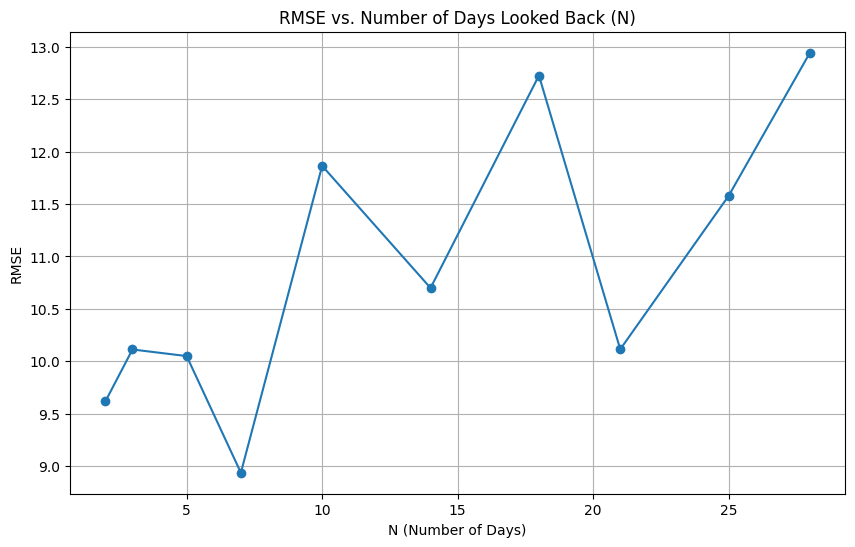

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(N_values, rmse_results, marker='o')
plt.title('RMSE vs. Number of Days Looked Back (N)')
plt.xlabel('N (Number of Days)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

## Lift chart

Plotting the best N value's model regression chart:


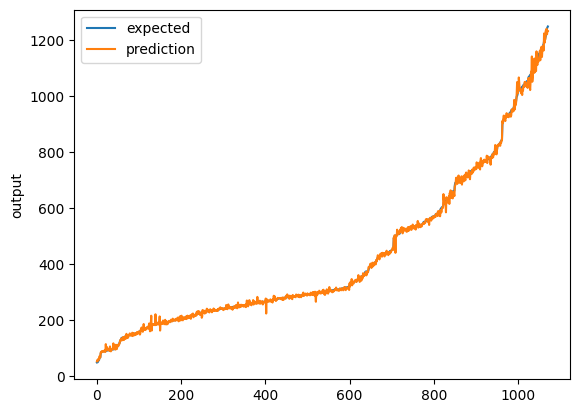

In [ ]:
print("Plotting the best N value's model regression chart:")
chart_regression(best_predictions, best_actuals)